#Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series 

## Tsaniyah Nur Kholilah
Proyek ini bertujuan untuk mempelajari Machine Learning berdasarkan Neural Network dengan data Time Series. Dataset yang digunakan adalah [Majority City Climate Change](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByMajorCity.csv) from Kaggle. Berdasarkan eksploratory data analisis berikut, dataset yang dipilih adalah data Averange Temperature China pada rentang waktu 1990 - 2013. 

1. Dataset > 10.000 sampel, yakni 23175 sampel.
2. Menggunakan LSTM dalam arsitektur model.
3. Validation set sebesar 20% dari total dataset.
4. Model harus menggunakan model sequential.
5. Harus menggunakan Learning Rate pada Optimizer.
6. MAE < 10% skala data.

+ Dataset sebaiknya memiliki banyak sampel
+ Mengimplementasikan Callback
+ Menampilkan plot loss dan akurasi pada saat training dan validation.


In [1]:
# import library
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
import matplotlib.pyplot as plt

## Mengunduh dataset Global Land Temperature By Majority City dari Kaggle

Dataset ini dipilih karena memuat Time Series dan berisi 239177 sampel.

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tsaniyah","key":"49ce95dd3c260aea5a6e2dbed864f12c"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-07-07 19:18:09           9163  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5617  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2034  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2399  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [8]:
!kaggle datasets download 'berkeleyearth/climate-change-earth-surface-temperature-data' -p /content/sample_data/ --unzip

 98% 83.0M/84.7M [00:01<00:00, 52.3MB/s]
100% 84.7M/84.7M [00:01<00:00, 76.2MB/s]


In [9]:
!mkdir climate-change-earth-surface-temperature-data
!unzip climate-change-earth-surface-temperature-data.zip -d climate-change-earth-surface-temperature-data
!ls climate-change-earth-surface-temperature-data

unzip:  cannot find or open climate-change-earth-surface-temperature-data.zip, climate-change-earth-surface-temperature-data.zip.zip or climate-change-earth-surface-temperature-data.zip.ZIP.


## Load Dataset By Country

In [10]:
df = pd.read_csv('/content/sample_data/GlobalLandTemperaturesByMajorCity.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [11]:
df.shape

(239177, 7)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB



## Data Cleaning

Menghapus dataset yang tidak memiliki nilai.

In [13]:
# Mengetahui data yang NaN
df.isnull().sum()

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [14]:
# Menghapus data yang kosong
df.dropna(subset=['AverageTemperature'],inplace=True)
df.dropna(subset=['AverageTemperatureUncertainty'],inplace=True)
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

## Memilih negara yang memiliki sampel paling banyak

Pada proyek ini mengabaikan nama kota, karena sampel dari sebuah kota memiliki lebih sedikit sampel daripada sebuah negara. Begitu halnya dengan data geografi seperti Latitute dan Longitude tidak diperlukan dalam proyek ini. 

In [15]:
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude'],
      dtype='object')

In [16]:
df.drop(['City','Latitude','Longitude'], axis=1, inplace=True)
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1849-01-01,26.704,1.435,Côte D'Ivoire
1,1849-02-01,27.434,1.362,Côte D'Ivoire
2,1849-03-01,28.101,1.612,Côte D'Ivoire
3,1849-04-01,26.140,1.387,Côte D'Ivoire
4,1849-05-01,25.427,1.200,Côte D'Ivoire


In [17]:
df['Country'].unique()

array(["Côte D'Ivoire", 'Ethiopia', 'India', 'Syria', 'Egypt', 'Turkey',
       'Iraq', 'Thailand', 'Brazil', 'Germany', 'Colombia',
       'South Africa', 'Morocco', 'China', 'United States', 'Senegal',
       'Tanzania', 'Bangladesh', 'Pakistan', 'Zimbabwe', 'Vietnam',
       'Nigeria', 'Indonesia', 'Saudi Arabia', 'Afghanistan', 'Ukraine',
       'Congo (Democratic Republic Of The)', 'Peru', 'United Kingdom',
       'Angola', 'Spain', 'Philippines', 'Iran', 'Australia', 'Mexico',
       'Somalia', 'Canada', 'Russia', 'Japan', 'Kenya', 'France', 'Burma',
       'Italy', 'Chile', 'Dominican Republic', 'South Korea', 'Singapore',
       'Taiwan', 'Sudan'], dtype=object)

In [18]:
df_indo = df.loc[df['Country'].isin(['Indonesia'])]
df_indo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3758 entries, 99236 to 213950
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             3758 non-null   object 
 1   AverageTemperature             3758 non-null   float64
 2   AverageTemperatureUncertainty  3758 non-null   float64
 3   Country                        3758 non-null   object 
dtypes: float64(2), object(2)
memory usage: 146.8+ KB


Indonesia memiliki sampel < 10000, sehingga tidak dipilih.

In [19]:
import seaborn as sns

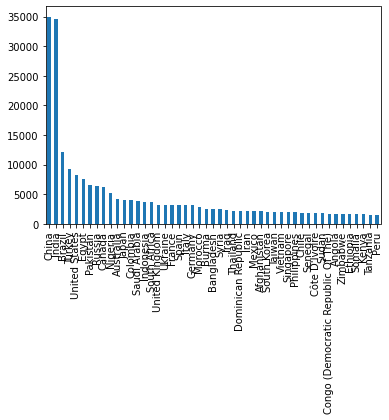

In [20]:
df_country = df[['dt','Country']]
df_country.Country.value_counts().plot(kind='bar')

Data yang digunakan pada proyek ini yakni negara dengan sampel terbesar yakni Data dari China. 

In [21]:
df_china = df.loc[df['Country'].isin(['China'])]
df_china.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,34952.000000,34952.000000
mean,11.793666,0.890271
std,11.380202,0.719471
min,-26.772000,0.056000
25%,3.819000,0.324000
50%,13.600000,0.629000
75%,21.261000,1.299000
max,31.233000,6.870000


In [22]:
df_china.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34952 entries, 47038 to 239175
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             34952 non-null  object 
 1   AverageTemperature             34952 non-null  float64
 2   AverageTemperatureUncertainty  34952 non-null  float64
 3   Country                        34952 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


In [23]:
df.drop(['Country'], axis=1, inplace=True)
df.reset_index(drop=True)

,dt,AverageTemperature,AverageTemperatureUncertainty
0,1849-01-01,26.704,1.435
1,1849-02-01,27.434,1.362
2,1849-03-01,28.101,1.612
3,1849-04-01,26.140,1.387
4,1849-05-01,25.427,1.200
...,...,...,...
228170,2013-04-01,12.563,1.823
228171,2013-05-01,18.979,0.807
228172,2013-06-01,23.522,0.647
228173,2013-07-01,25.251,1.042


## EDA data untuk mengetahui rentang waktu yang diplih 

Text(0.5, 0, 'Datetime')

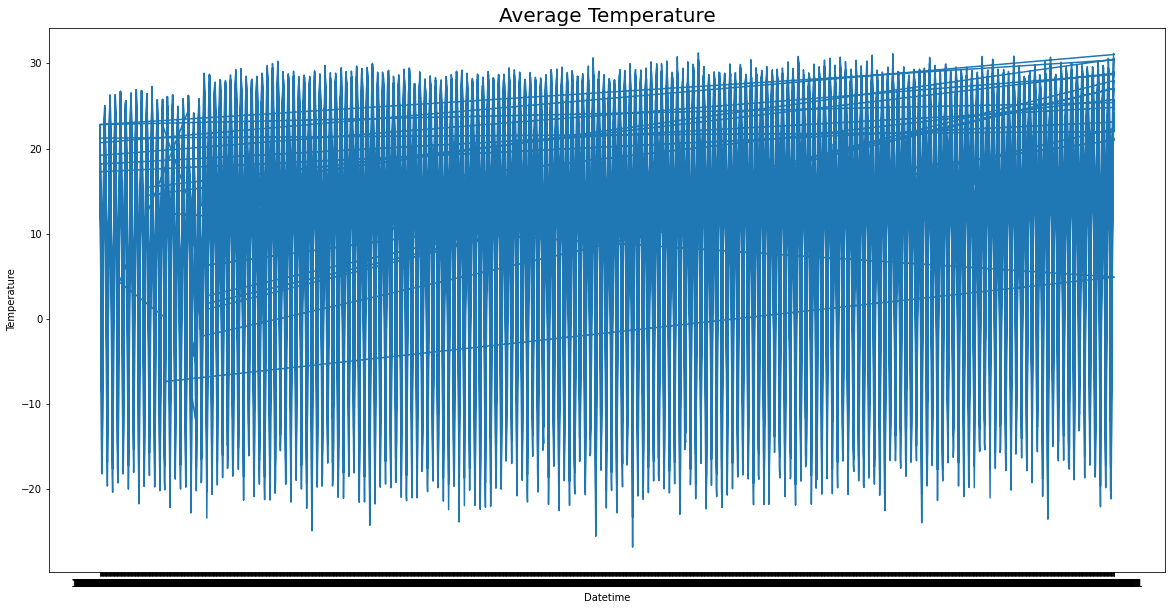

In [24]:
dates = df_china['dt'].values
temp  = df_china['AverageTemperature'].values
 
 
plt.figure(figsize=(20,10))
plt.plot(dates, temp)
plt.title('Average Temperature',
          fontsize=20)
plt.ylabel('Temperature')
plt.xlabel('Datetime')

Average Temperature pada data di awal grafik atau data dari waktu yang lama memiliki pola yang berbeda dibanding data setelahnya, sehingga perlu disubset pada data yang tidak terlalu lama.

In [25]:
df_china["dt"].min()

'1820-08-01'

In [26]:
df_china["dt"].max()

'2013-08-01'

In [27]:
df_china["dt"].describe()

count          34952
unique          2317
top       1913-12-01
freq              16
Name: dt, dtype: object

Time series yang diambil berdasarkan EDA tersebut, maka diambil dari 1900 hingga 2013.

In [28]:
df_china['dt'] = pd.to_datetime(df_china['dt']) 
df_china.loc[(df_china['dt'] > '1900-01-01') & (df_china['dt'] <= '2013-09-01')]

df1 = df_china.loc[(df_china['dt'] > '1900-01-01') & (df_china['dt'] <= '2013-09-01')]
display(df1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
47992,1900-02-01,-11.314,0.912,China
47993,1900-03-01,-2.830,1.422,China
47994,1900-04-01,6.698,0.847,China
47995,1900-05-01,14.996,1.048,China
47996,1900-06-01,20.378,1.451,China
...,...,...,...,...
239171,2013-04-01,12.563,1.823,China
239172,2013-05-01,18.979,0.807,China
239173,2013-06-01,23.522,0.647,China
239174,2013-07-01,25.251,1.042,China


Text(0.5, 0, 'Datetime')

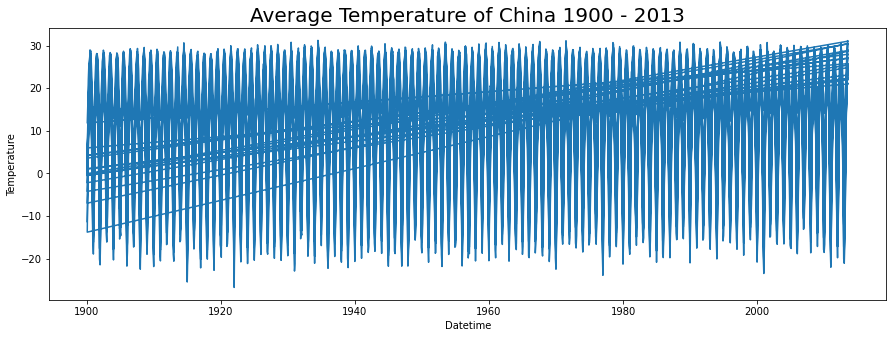

In [ ]:
dates = df1['dt'].values
temp  = df1['AverageTemperature'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Average Temperature of China 1900 - 2013',
          fontsize=20)
plt.ylabel('Temperature')
plt.xlabel('Datetime')

Data yang digunakan dalam ML yaitu Average Temperature of China 1900 - 2013 dengan 239175 sampel.

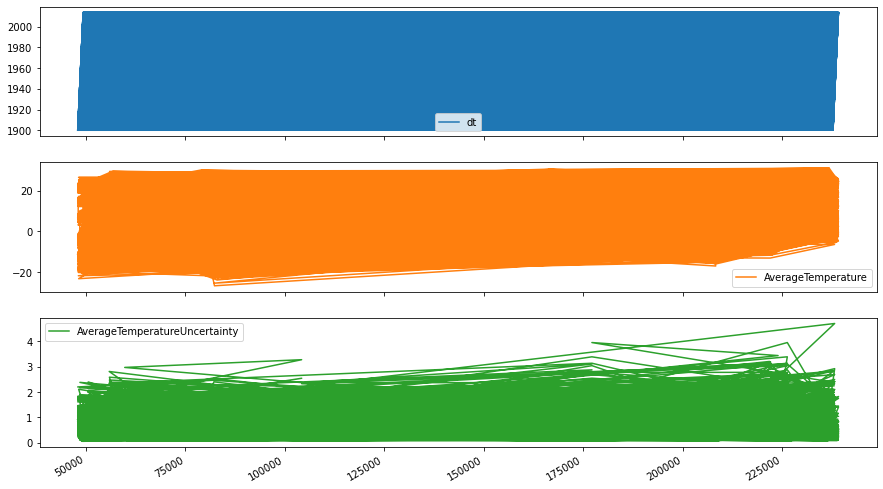

In [30]:
df1_plot = df1
df1_plot[df1_plot.columns.to_list()].plot(subplots=True, figsize=(15, 9))
plt.show()

Data tidak ordered, sehingga harus diurutkan.

In [31]:
df2 = df1.sort_values('dt') # diurutkan berdasarkan waktu
display(df2)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
47992,1900-02-01,-11.314,0.912,China
235495,1900-02-01,4.274,1.301,China
104271,1900-02-01,1.129,1.731,China
165792,1900-02-01,3.578,0.685,China
223983,1900-02-01,-0.211,2.156,China
...,...,...,...,...
227663,2013-08-01,27.054,0.233,China
167154,2013-08-01,30.407,0.614,China
236857,2013-08-01,31.050,0.501,China
178563,2013-08-01,27.054,0.233,China


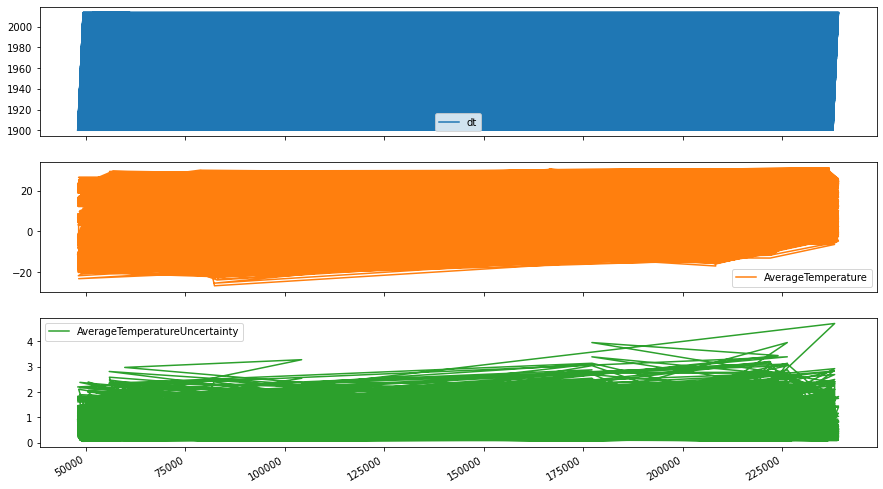

In [32]:
df2_plot = df2
df2_plot[df2_plot.columns.to_list()].plot(subplots=True, figsize=(15, 9))
plt.show()

Text(0.5, 0, 'Datetime')

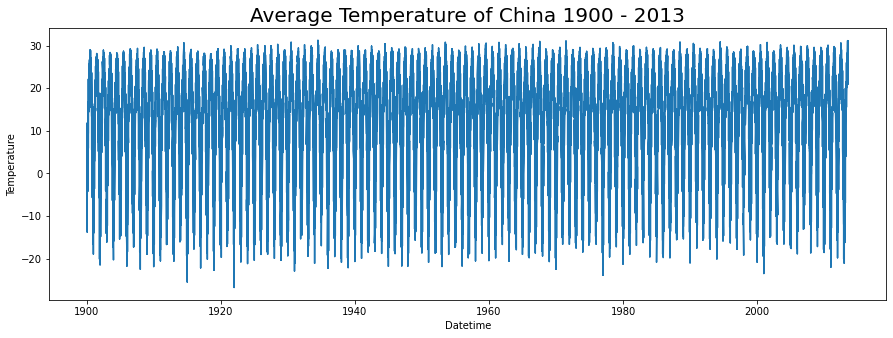

In [33]:
dates = df2['dt'].values
temp  = df2['AverageTemperature'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Average Temperature of China 1900 - 2013',
          fontsize=20)
plt.ylabel('Temperature')
plt.xlabel('Datetime')

Data sudah ordered, sehingga dapat dilanjutkan tahap berikutnya.

In [ ]:
#from google.colab import files

#with open('AverageTemperatureofChina1900-2013.csv', 'w') as f:
  #f.write('df1')

#files.download('AverageTemperatureofChina1900-2013.csv')

## Split dataset

In [35]:
# Split dataset untuk data train 80% dan validation 20%
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, train_size=0.8, test_size=0.2, shuffle = False )

In [38]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  17446
Total Data Validation :  4362


In [42]:
#Total sampel data 
17446 + 4362

21808

## Membangun Model Machine Learning

In [ ]:
#tf.keras.backend.set_floatx('float64')

In [43]:
# Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [44]:
train_set = windowed_dataset(temp, window_size=64, batch_size=200, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [45]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [53]:
# Penghitungan nilai MAE untuk Callback
MAE = (df2['AverageTemperature'].max() - df2['AverageTemperature'].min()) * 10/100
print(MAE)

5.8004999999999995


In [ ]:
# Saran reviwer sebaiknya tidak menggunakan Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<6.5 and logs.get('val_mae')<6.5):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
#val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

In [47]:
history = model.fit(train_set,epochs=100, 
                    #validation_data = val_set, callbacks=[callbacks]
                    )

Epoch 1/100
109/109 [==============================] - 16s 36ms/step - loss: 13.6029 - mae: 14.0964
Epoch 2/100
109/109 [==============================] - 4s 35ms/step - loss: 13.0955 - mae: 13.5895
Epoch 3/100
109/109 [==============================] - 4s 36ms/step - loss: 12.2133 - mae: 12.7077
Epoch 4/100
109/109 [==============================] - 4s 35ms/step - loss: 10.3090 - mae: 10.7996
Epoch 5/100
109/109 [==============================] - 4s 36ms/step - loss: 7.6526 - mae: 8.1410
Epoch 6/100
109/109 [==============================] - 4s 36ms/step - loss: 5.8920 - mae: 6.3741
Epoch 7/100
109/109 [==============================] - 4s 36ms/step - loss: 4.6597 - mae: 5.1388
Epoch 8/100
109/109 [==============================] - 4s 35ms/step - loss: 4.0866 - mae: 4.5615
Epoch 9/100
109/109 [==============================] - 4s 35ms/step - loss: 3.8899 - mae: 4.3620
Epoch 10/100
109/109 [==============================] - 4s 35ms/step - loss: 3.8387 - mae: 4.3094
Epoch 11/100
109/109

MAE 4,1

KeyError: ignored

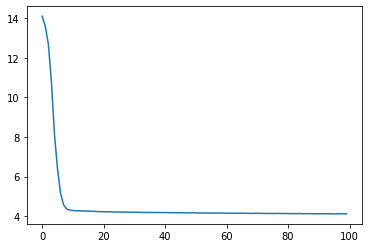

In [48]:
# plot Akurasi
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model Berdasarkan MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

KeyError: ignored

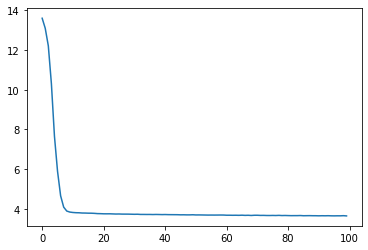

In [49]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 120)         29760     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120)               86880     
_________________________________________________________________
dense (Dense)                (None, 30)                3630      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 120,591
Trainable params: 120,591
Non-trainable params: 0
_________________________________________________________________


In [50]:
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

In [51]:
history = model.fit(train_set,epochs=100, validation_data = val_set, 
                    #callbacks=[callbacks]
                    )

Epoch 1/100
109/109 [==============================] - 6s 50ms/step - loss: 3.6480 - mae: 4.1182 - val_loss: 3.4938 - val_mae: 3.9668
Epoch 2/100
109/109 [==============================] - 4s 40ms/step - loss: 3.6405 - mae: 4.1113 - val_loss: 3.4823 - val_mae: 3.9529
Epoch 3/100
109/109 [==============================] - 4s 40ms/step - loss: 3.6455 - mae: 4.1162 - val_loss: 3.4759 - val_mae: 3.9455
Epoch 4/100
109/109 [==============================] - 4s 40ms/step - loss: 3.6466 - mae: 4.1169 - val_loss: 3.4761 - val_mae: 3.9456
Epoch 5/100
109/109 [==============================] - 4s 39ms/step - loss: 3.6438 - mae: 4.1143 - val_loss: 3.4753 - val_mae: 3.9444
Epoch 6/100
109/109 [==============================] - 5s 41ms/step - loss: 3.6374 - mae: 4.1079 - val_loss: 3.4829 - val_mae: 3.9509
Epoch 7/100
109/109 [==============================] - 4s 40ms/step - loss: 3.6496 - mae: 4.1203 - val_loss: 3.4825 - val_mae: 3.9515
Epoch 8/100
109/109 [==============================] - 4s 39ms

MAE 4.0, Val-MAE 3.9

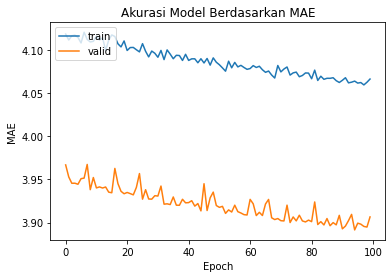

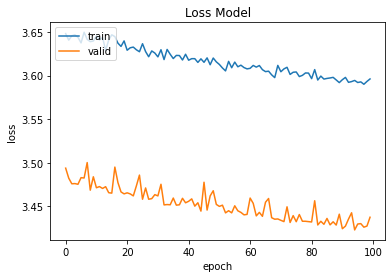

In [52]:
# plot Akurasi
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model Berdasarkan MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Pengembangan model machine learning time series average temperature China 1900 - 2013 menggunakan data > 23K sampel, serta menunjukkan nilai MAE <10% skala data, yaitu MAE 5,7 dan Validasi MAE 4,5.

# Thank you for reviewing my project!

Tsaniyah Nur Kholilah. 2021


tsaniyahnur.kholilah@gmail.com


https://www.dicoding.com/users/tsancode


Referensi: 

1. Easiest way to download kaggle data in Google Colab. https://www.kaggle.com/general/74235

2. Data Climate Change. https://data.world/data-society/global-climate-change-data
